# LSTM on Real Time Series Dataset:

<img src="./pictures/FRED_dataset_01.png"
     style="float: left; margin-right: 10px; width: 700px"/>

In [1]:
# basic libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Tensorflow:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator


# Sklearn:
from sklearn.preprocessing import MinMaxScaler

In [2]:
# reading .csv files data:
df = pd.read_csv("./data/Advance Retail Sales.csv")

In [3]:
# looking at the head of data:
df.head()

,DATE,Sales
0,1/1/1992,6938
1,2/1/1992,7524
2,3/1/1992,8475
3,4/1/1992,9401
4,5/1/1992,9558


In [4]:
# converting date object into data-time object:
df = pd.read_csv("./data/Advance Retail Sales.csv", parse_dates=True, index_col="DATE")

In [5]:
# again looking at head of data:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


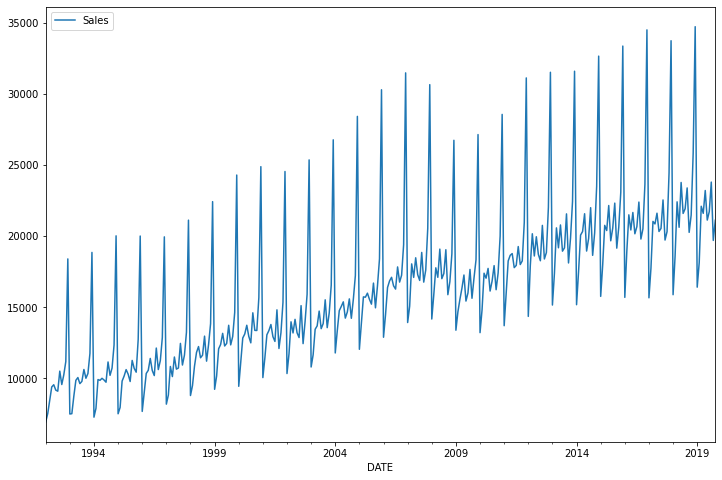

In [6]:
# plotting data we have:
df.plot(figsize=(12,8))
plt.show()

In [7]:
# train / test split:

test_size = 18                       # 18 months = 1 year and half
test_index = len(df) - test_size
train_data = df.iloc[:test_index]
test_data = df.iloc[test_index:]


In [8]:
# printing shape of our data:
print("train_data shape: ", train_data.shape)
print("test_data shape: ", test_data.shape)

train_data shape:  (316, 1)
test_data shape:  (18, 1)


In [9]:
# scaling data: (normalizing data)
# MinMaxScaler object:
MinMax_scaler= MinMaxScaler()

MinMax_scaler.fit(train_data)

train_data_scaled = MinMax_scaler.transform(train_data)
test_data_scaled = MinMax_scaler.transform(test_data)

In [10]:
# using TimeseriesGenerator:
sequence_length = 12                 # 12 month = 1 year

# Timeseries Generator for train data:
train_generator = TimeseriesGenerator(data=train_data_scaled,
                                      targets=train_data_scaled,
                                      length=sequence_length,
                                      batch_size=1)

# Timeseries Generator for test data:
test_generator = TimeseriesGenerator(data=test_data_scaled,
                                     targets=test_data_scaled,
                                     length=sequence_length,
                                     batch_size=1)

In [11]:
# Early Stopping:
early_stop = EarlyStopping(monitor="val_loss",
                           patience=2)

In [12]:
# creating our model:
number_of_features = 1
# lstm layer:
lstm_model = Sequential()
lstm_model.add(LSTM(units=100,
                    activation="relu",
                    input_shape=(sequence_length, number_of_features)))
# output layer:
lstm_model.add(Dense(1))

# compiling the model:
lstm_model.compile(optimizer="adam", 
                   loss="mse")

In [13]:
# summary of the model:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [14]:
# training the model (fitting the model to data):
# fitting the model to data:
lstm_model.fit(train_generator,
               validation_data=test_generator,
               epochs=20,
               callbacks=early_stop)

Epoch 1/20
304/304 [==============================] - 5s 10ms/step - loss: 0.0248 - val_loss: 0.0035
Epoch 2/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0167 - val_loss: 0.0181
Epoch 3/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0085 - val_loss: 0.0014
Epoch 4/20
304/304 [==============================] - 3s 8ms/step - loss: 0.0048 - val_loss: 8.4780e-04
Epoch 5/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0025 - val_loss: 3.9999e-04
Epoch 6/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 7/20
304/304 [==============================] - 3s 9ms/step - loss: 0.0015 - val_loss: 4.9694e-04


In [15]:
# saving the model:
lstm_model.save("./saved_model/lstm_model_01.h5")

In [16]:
# losses:
losses = pd.DataFrame(data=lstm_model.history.history)
losses

,loss,val_loss
0,0.024768,0.003476
1,0.016660,0.018124
2,0.008457,0.001428
3,0.004759,0.000848
4,0.002468,0.000400
5,0.001542,0.001218
6,0.001479,0.000497


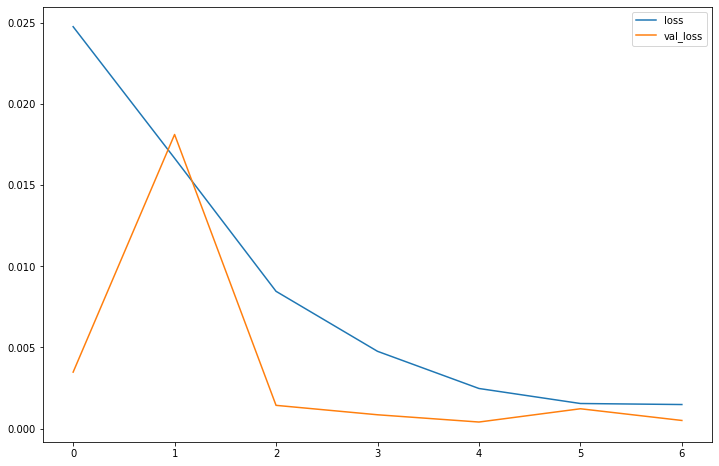

In [17]:
# plotting our losses:
losses.plot(figsize=(12,8))
plt.show()

In [18]:
# evaluatin on test data:
test_predictions = []
first_eval_batch = train_data_scaled[-sequence_length:]
current_batch = first_eval_batch.reshape((1, sequence_length, number_of_features))

for i in range(len(test_data)):
    # get prediction of one time stamp ahead ([0] is for grabbing just the number inside)
    current_pred = lstm_model.predict(current_batch)[0]
    # storing prediction in test_predictions
    test_predictions.append(current_pred)
    # update bach to now including prediction and dropping first value
    current_batch = np.append(current_batch[:, 1:, ], [[current_pred]], axis=1)
    

e:\app_special\anaconda_onwin\envs\mytfenv\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


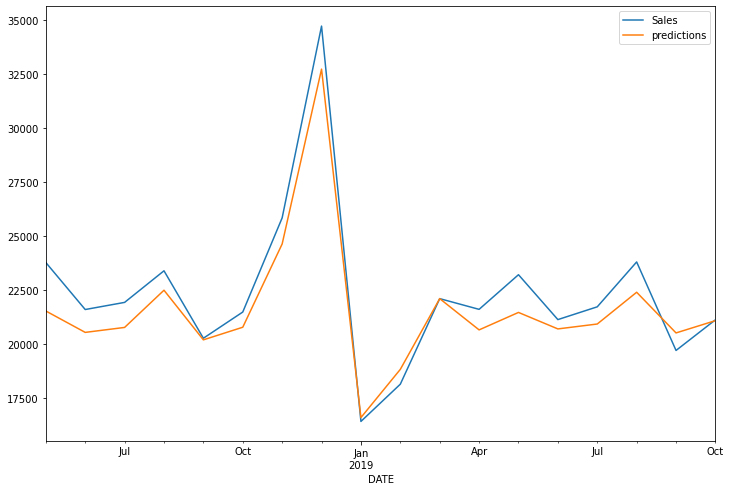

In [19]:
# plotting true and predicitons:
true_scaled_predictions = MinMax_scaler.inverse_transform(test_predictions)
test_data["predictions"] = true_scaled_predictions
test_data.plot(figsize=(12,8))
plt.show()

# The End